# Full Image and Mask View

image loaded!



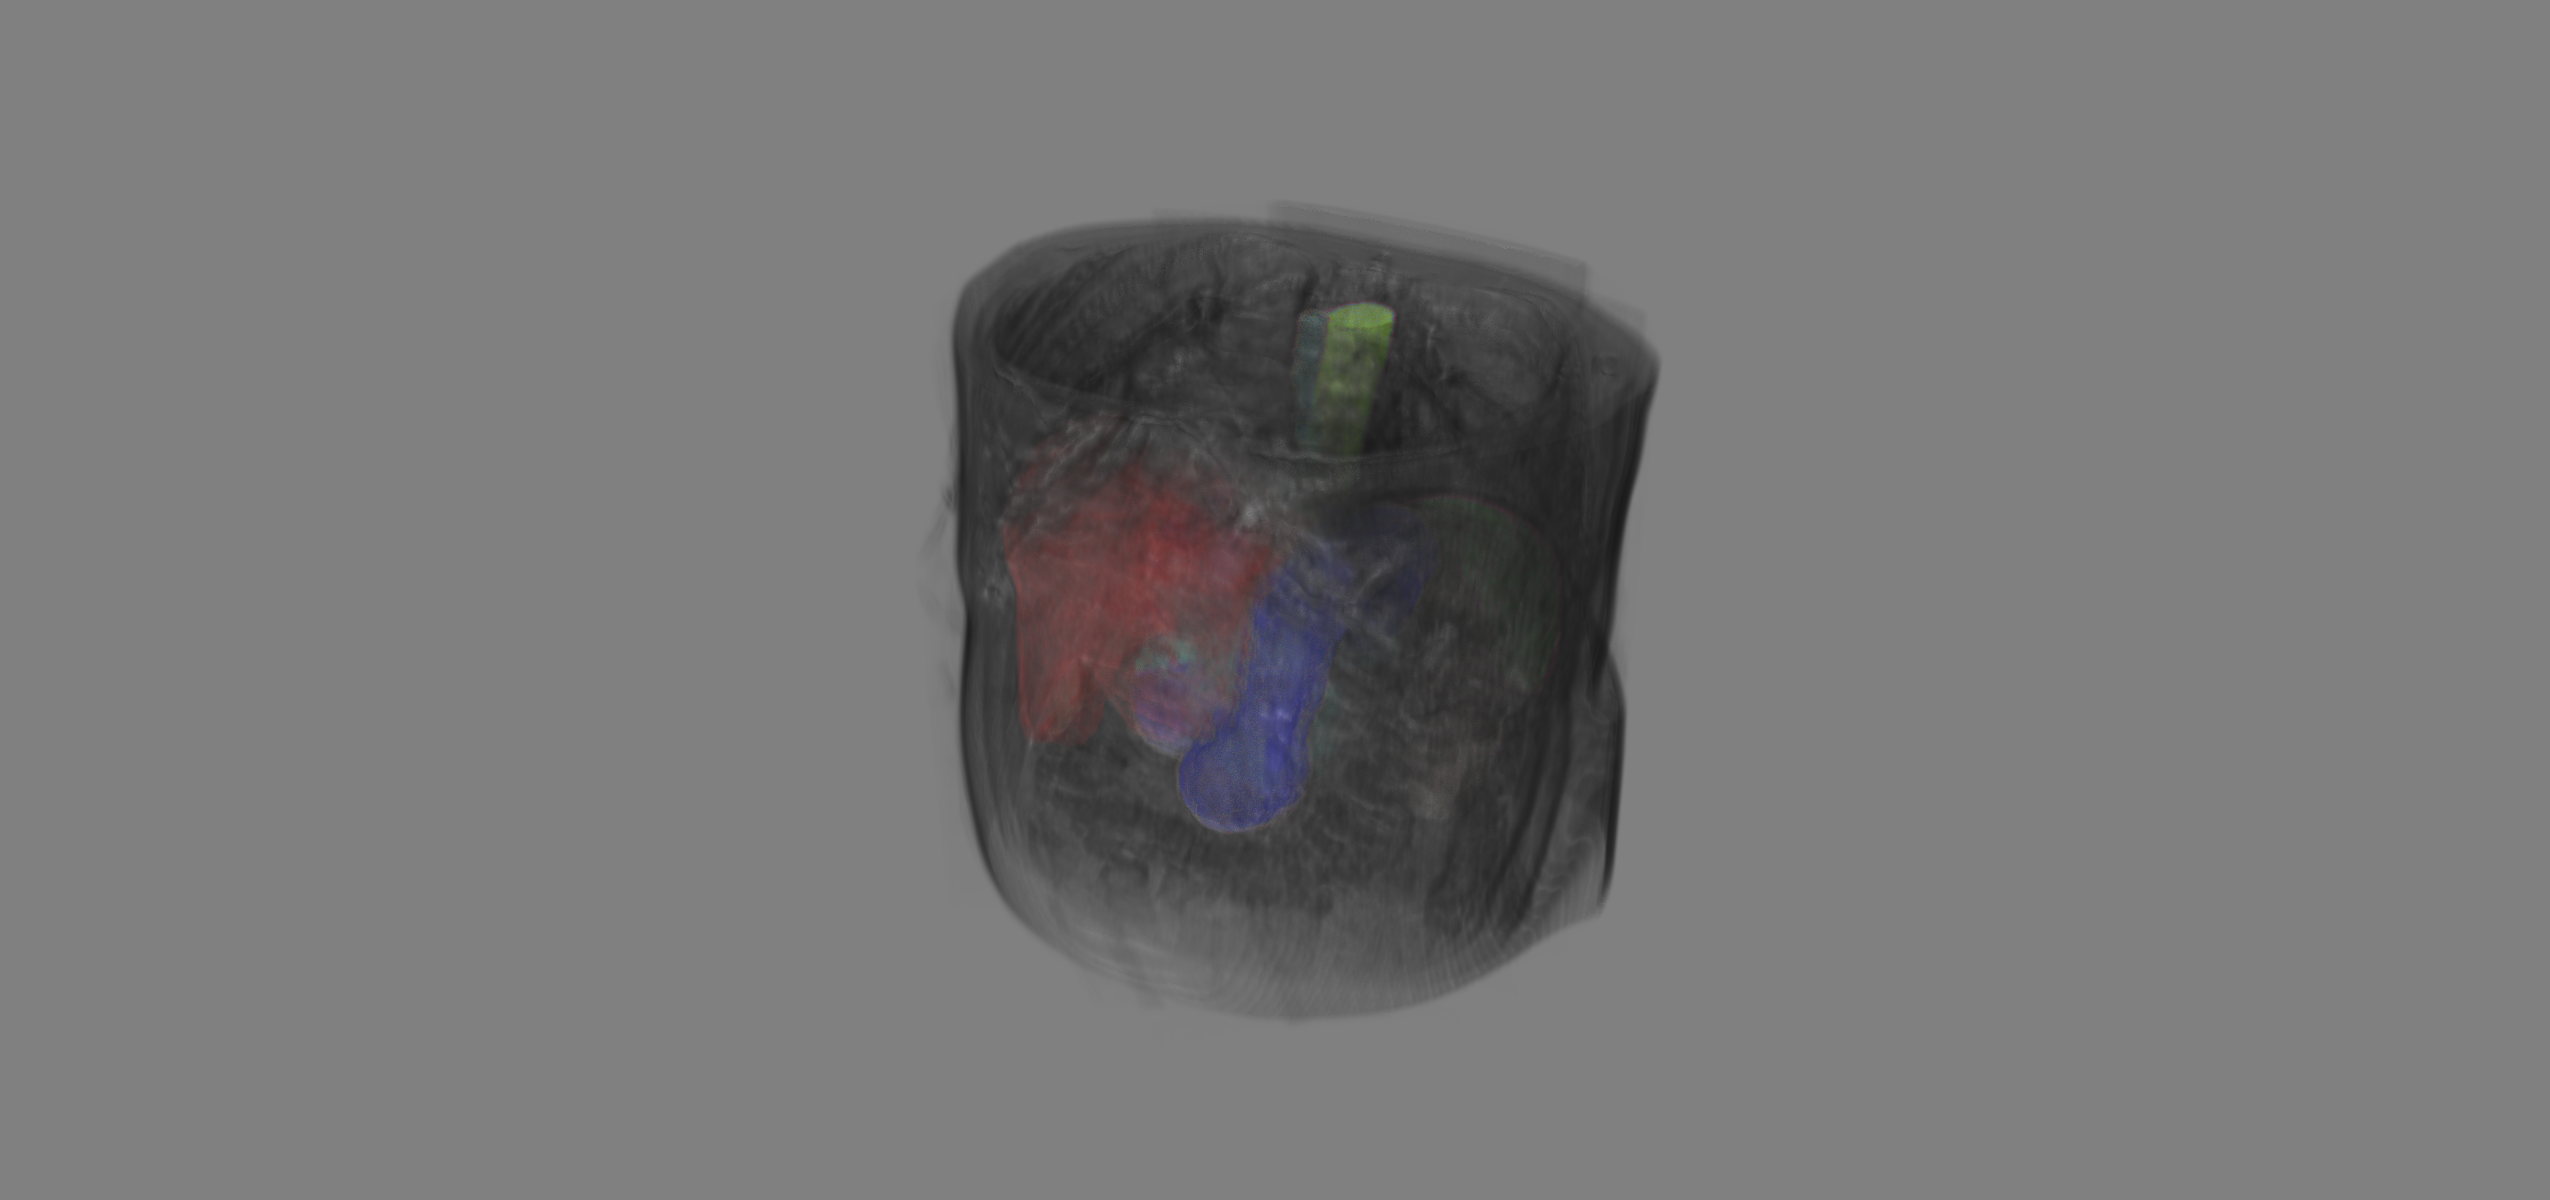
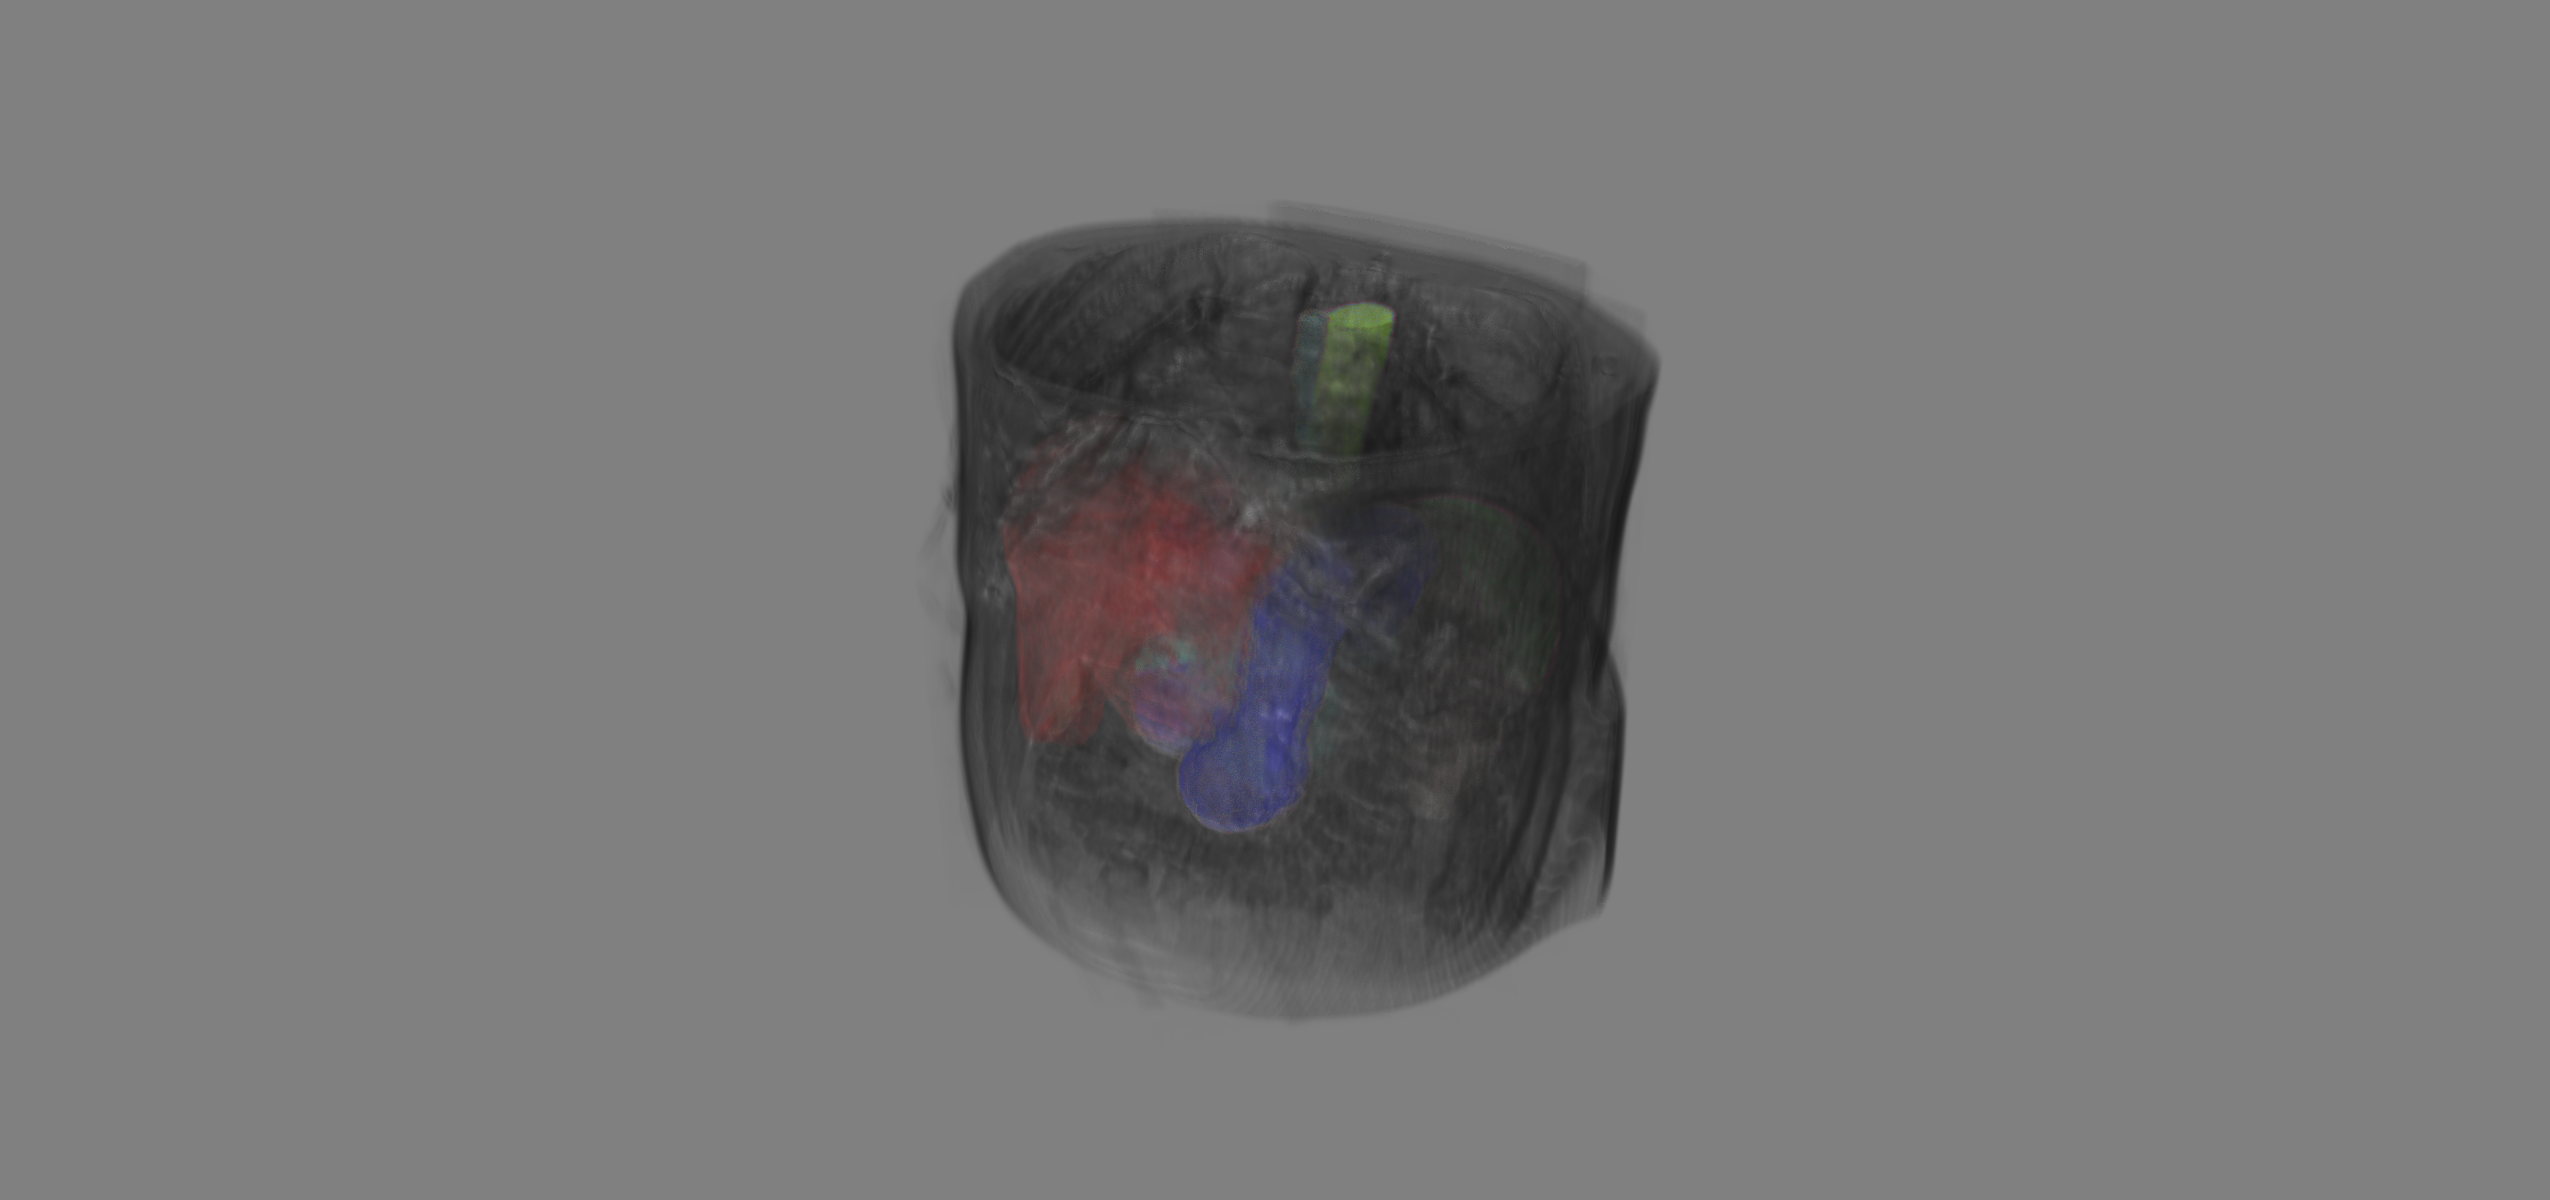

<IPython.core.display.Javascript object>

In [1]:
import SimpleITK as sitk
import itkwidgets
import torch
import numpy as np
from itkwidgets import view

from ct_sam.utils.frame import voxel_to_world
from ct_sam.builder import build_sam
from ct_sam.predictor import SamPredictor
from ct_sam.utils.resample import flip_itkimage_torai, resample_itkimage_torai, crop_roi_with_center


pid = "FLARE22_Tr_0001"


image = sitk.ReadImage(f"../examples/{pid}_0000.nii.gz")
image = resample_itkimage_torai(image, [1.5, 1.5, 1.5], "linear", -1024)

mask_gt = None
try:
    mask_gt = sitk.ReadImage(f"../examples/{pid}.nii.gz")
    mask_gt = resample_itkimage_torai(mask_gt, [1.5, 1.5, 1.5], interpolator="nearest", pad_value=0)

except Exception as e:
    print(f"read mask failed: {e}")


def compute_dsc_np(predict, targets, threshold=0.0, smooth=1):
    intersection = (predict * targets).sum()
    dice = (2.0 * intersection + smooth) / (predict.sum() + targets.sum() + smooth)
    return dice


def show(image: sitk.Image, mask: sitk.Image = None, predictor: SamPredictor = None, predict_mode: str = "patch"):
    image_np = sitk.GetArrayFromImage(image)
    mask_np = None
    if mask is not None:
        mask_np = sitk.GetArrayFromImage(mask)
    if predict_mode == "patch":
        viewer = view(image_np, label_image=mask_np, gradient_opacity=0.4, 
                      shadow_enabled=False, annotations=False, cmap="Grayscale", 
                      view_mode='Volume', sample_distance=0.5, blend_mode="Composite", predictor=predictor)
    elif predict_mode == "full_image":
        viewer = view(image_np, label_image=mask_np, gradient_opacity=0.4, 
                      shadow_enabled=False, annotations=False, cmap="Grayscale", 
                      view_mode='Volume', sample_distance=0.5, blend_mode="Composite", predictor=predictor, predict_mode=predict_mode, image_itk=image)
    else:
        raise ValueError("NotImplemented")
    return viewer

print("image loaded!")
show(image, mask_gt)

# Load Model Weights

In [2]:
%time
import os
import numpy as np
from ct_sam.utils.io_utils import load_module_from_file

checkpoint = "../../../ckpt_1000/params.pth"

config_file = os.path.join(os.path.dirname(checkpoint), "config.py")
assert os.path.isfile(config_file), "file config.py not found!"
cfg_module = load_module_from_file(config_file)
cfg = cfg_module.cfg

cfg.update({"checkpoint": checkpoint})
sam = build_sam(cfg)
if torch.cuda.is_available():
    sam.cuda()
predictor = SamPredictor(sam, cfg.dataset)
print("predictor device: ", predictor.device)


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.78 µs
predictor device:  cpu


# Crop and Patch Interaction

In [3]:
crop = True
if crop:
    center_v = [68, 134, 92]
    center_w = voxel_to_world(image, center_v)
    x_axis, y_axis, z_axis = np.array(image.GetDirection()).reshape(3, 3).transpose()
    image_patch = crop_roi_with_center(image, center_w, image.GetSpacing(), x_axis, y_axis, z_axis, [64, 64, 64], "linear", -1024)
    
    if mask_gt is not None:
        mask_gt_patch = crop_roi_with_center(mask_gt, center_w, mask_gt.GetSpacing(), x_axis, y_axis, z_axis, [64, 64, 64], "nearest", 0)
        mask_gt_patch = sitk.GetArrayFromImage(mask_gt_patch).astype(np.int32)
        print("mask cropped!")
    
    print("image cropped!")

predictor.set_image(image_patch)

full_size = image.GetSize()
patch_size = image_patch.GetSize()
print("full image size: ", full_size, "| patch size: ", patch_size)

mask cropped!
image cropped!
full image size:  (220, 220, 184) | patch size:  (64, 64, 64)



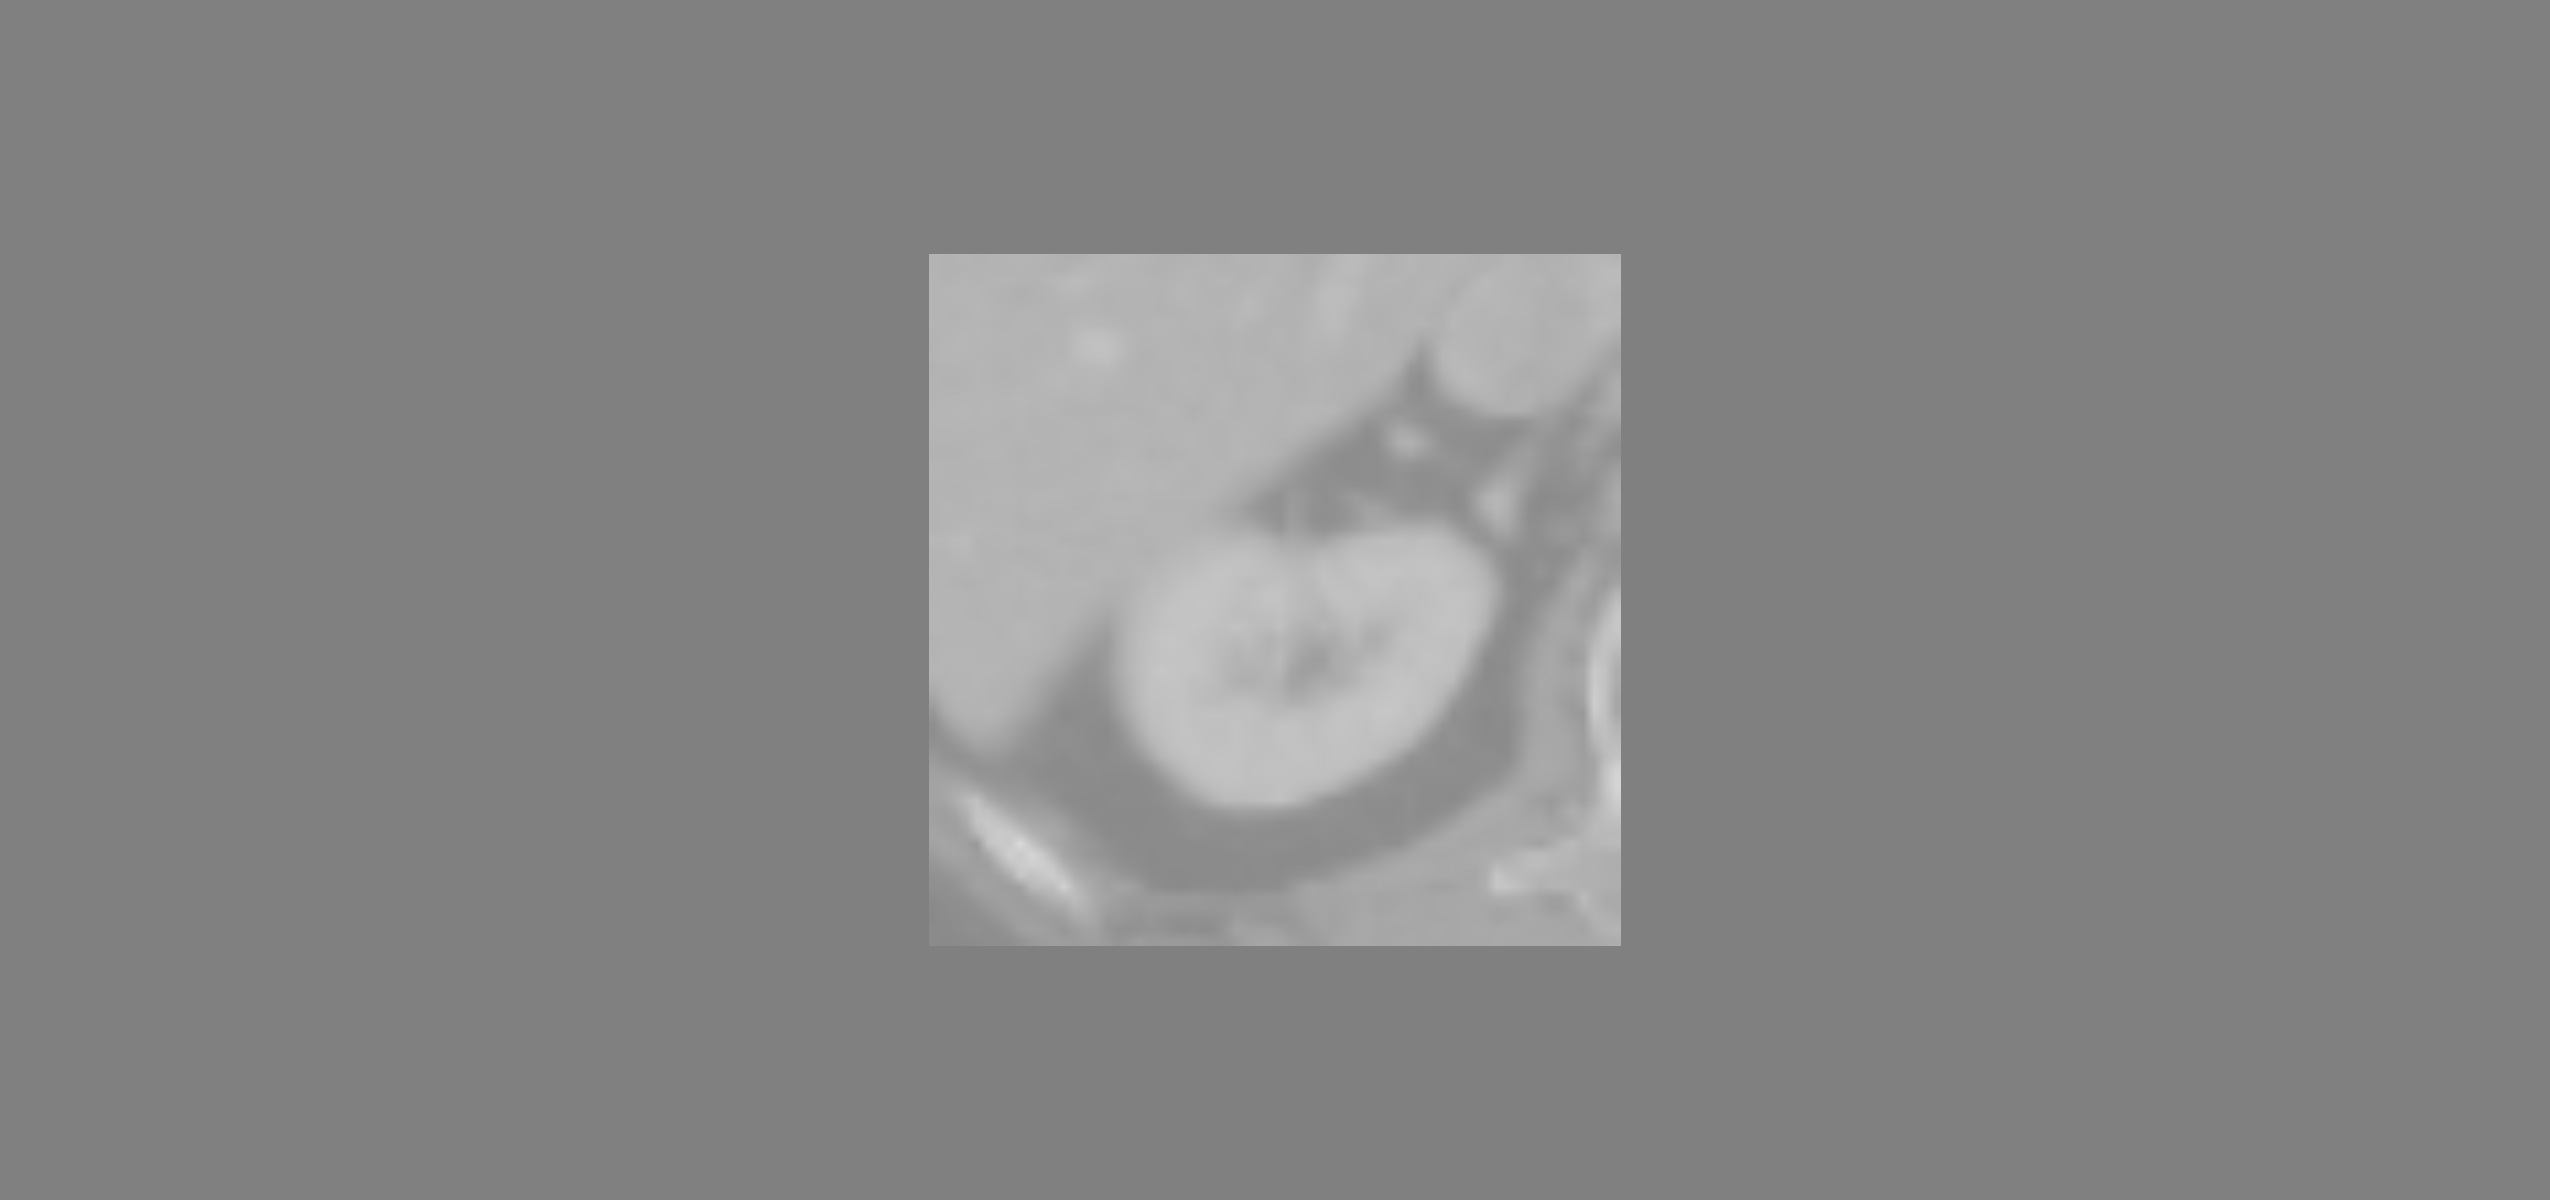
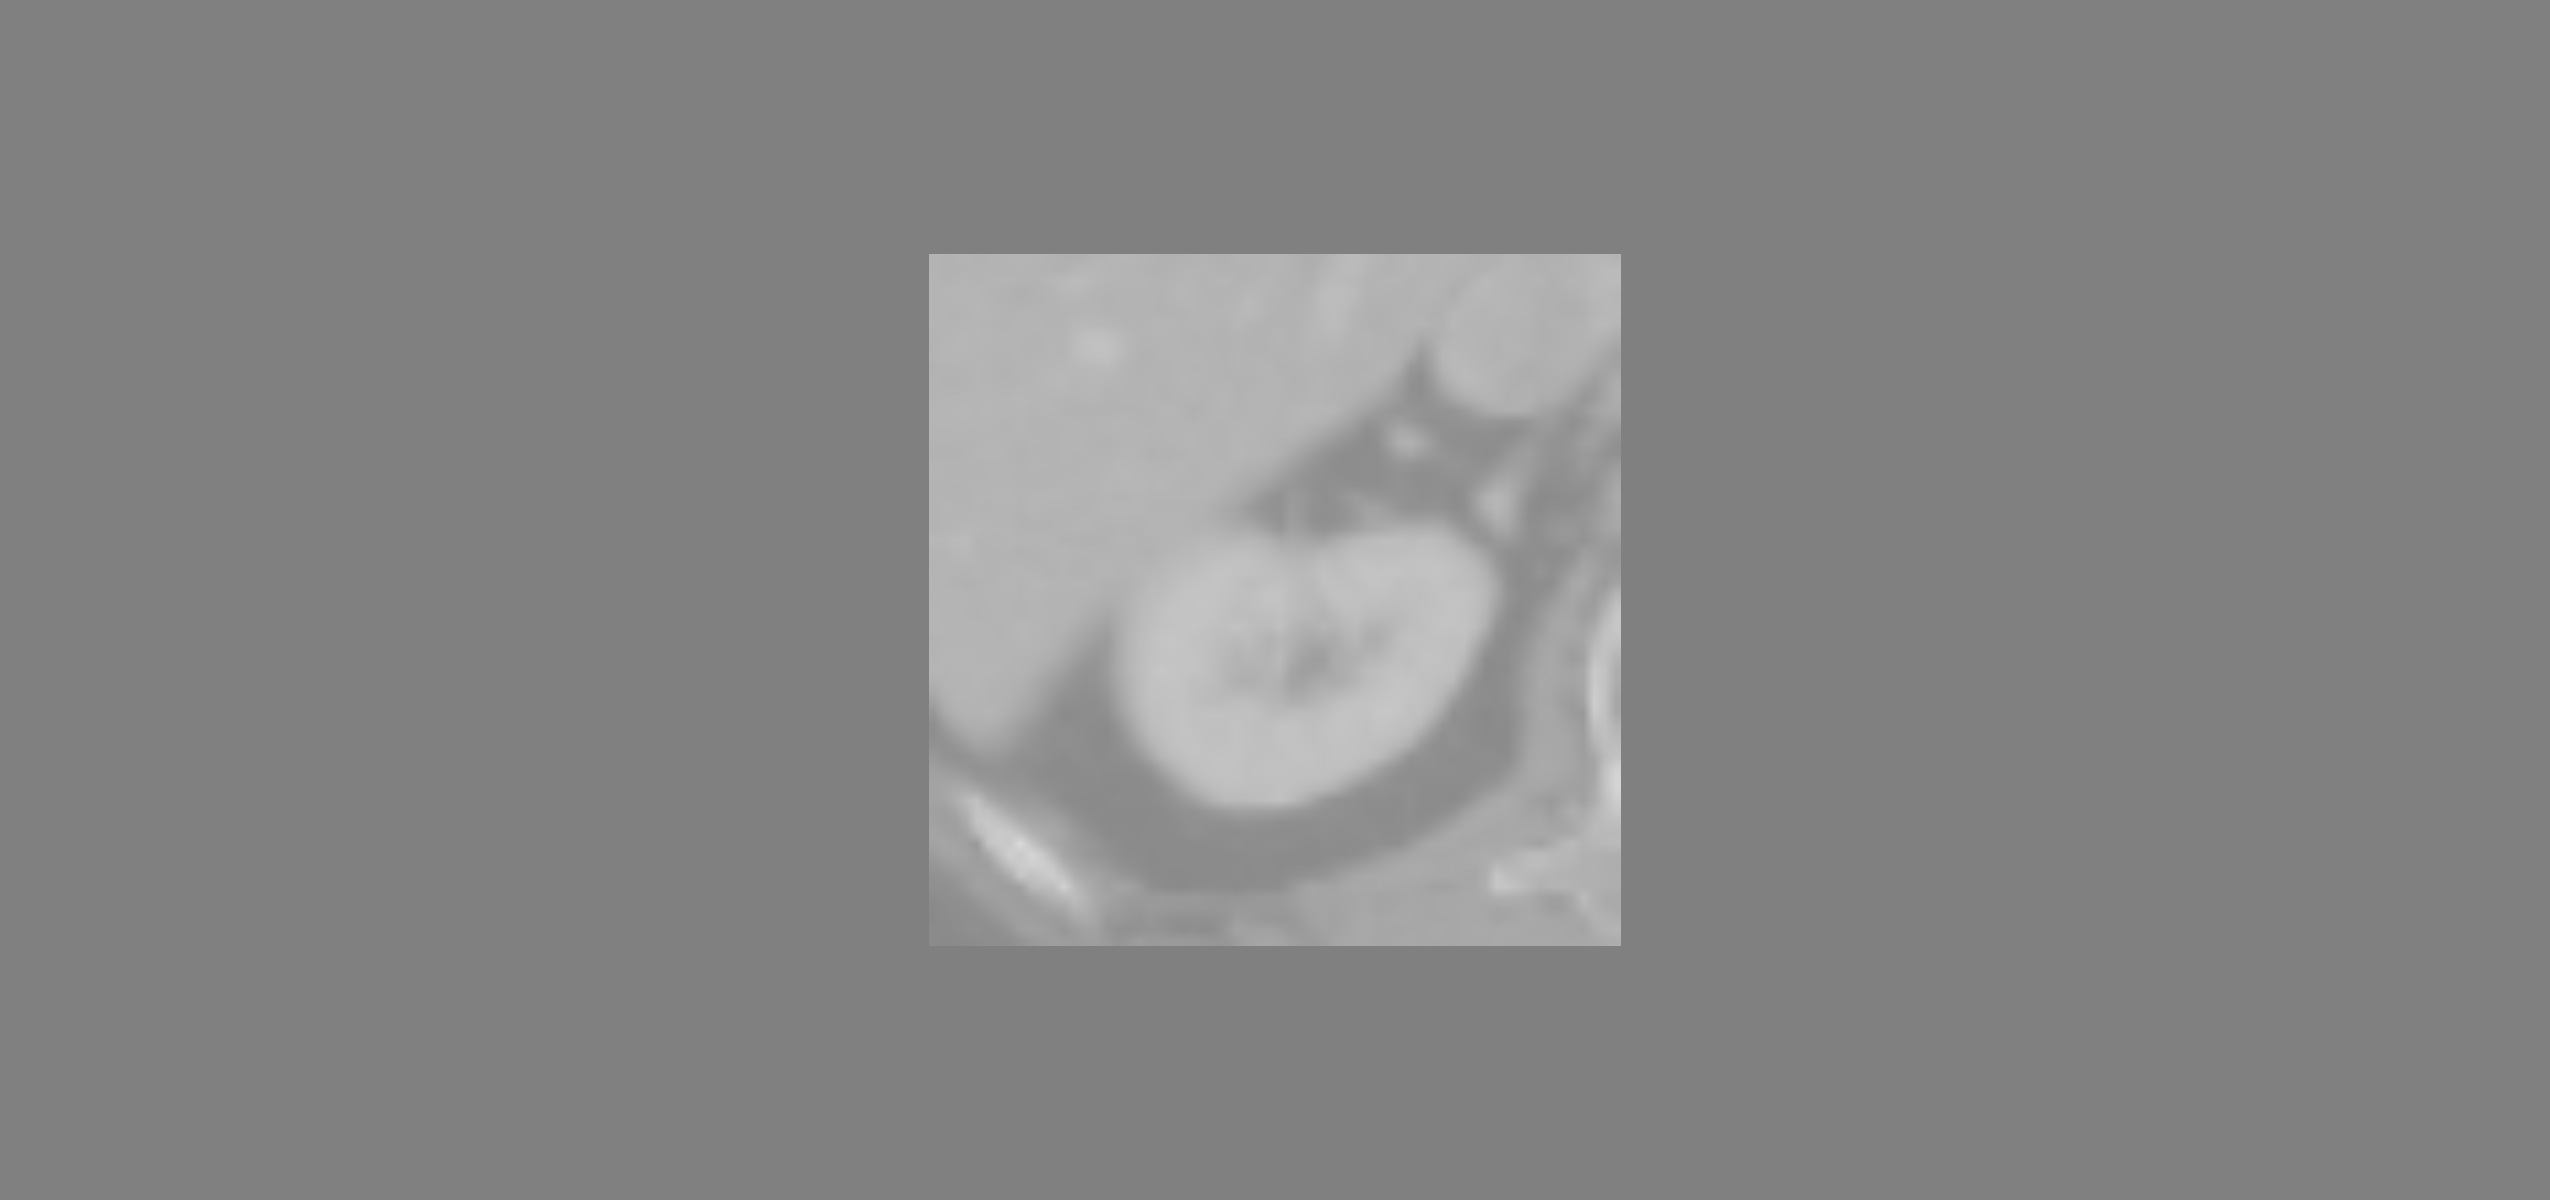

<IPython.core.display.Javascript object>

Output()

In [4]:
from ipywidgets import interact_manual, widgets, interactive_output, Button, VBox, HBox
from IPython.display import display
import numpy as np

box = VBox()

def get_axis_widget(axis="X", max=256):
    slider = widgets.IntSlider(min=0, max=max, step=1, value=max//2)
    text = widgets.BoundedIntText(value=slider.value, min=0, max=max, step=1)

    def update_slider(change):
        slider.value = change.new

    def update_text(change):
        text.value = change.new

    text.observe(update_slider, names="value")
    slider.observe(update_text, names="value")
    widget = widgets.HBox([widgets.Label(value=f'{axis} '), slider, text])
    return widget


def get_point_widget(size):
    x = widgets.BoundedIntText(value=size[0]//2, min=0, max=size[0]-1, step=1, description="X", layout={'width': '200px'})
    y = widgets.BoundedIntText(value=size[1]//2, min=0, max=size[1]-1, step=1, description="Y", layout={'width': '200px'})
    z = widgets.BoundedIntText(value=size[2]//2, min=0, max=size[2]-1, step=1, description="Z", layout={'width': '200px'})
    label = widgets.BoundedIntText(value=1, min=0, max=1, step=1, description="Label", layout={'width': '200px'})
    widget = HBox([x, y, z, label])
    return widget


def add_button_click(button):
    input_box = HBox()
    input_box.children = [get_point_widget(patch_size)]
    delete_button = Button(description='Delete', button_style="danger")
    delete_button.on_click(lambda button: delete_input_box(input_box))
    input_box.children += (delete_button,)
    box.children += (input_box,)


def delete_input_box(input_box):
    children_list = list(box.children)
    children_list.remove(input_box)
    box.children = tuple(children_list)
    display(box)


def prompt(viewer, points, labels):
    global mask_input, mask_gt_patch, predictor
    mask, scores, logits = predictor.predict(
        point_coords=points,
        point_labels=labels,
        multimask_output=False,
        mask_input=mask_input,
    )
    # any mask should also be converted into RAI orientation for visualization
    # mask = flip_itkimage_torai(mask, interpolator="nearest", pad_value=0)
    mask_input = logits
    msg = f"Prompt point: {points, labels}, Mask size: {mask.GetSize()}"
    
    if mask_gt is not None:
        p = points[0]
        target_label = mask_gt_patch[p[2], p[1], p[0]]
        mask_gt_bin = mask_gt_patch == target_label
        
        dsc = compute_dsc_np(sitk.GetArrayFromImage(mask), mask_gt_bin)
        msg += f", DSC: {dsc:.4f}"
    
    print(msg)
    viewer.set_label_image(sitk.GetArrayFromImage(mask))
    return viewer


def clear_button_click(button):
    global viewer, mask_input
    with out:
        mask_input = None
        viewer.points.clear()
        viewer.labels.clear()
        viewer.mask_input = None
        empty_mask = np.zeros(patch_size)
        viewer.set_label_image(empty_mask)
        print("Mask cleared!")


out = widgets.Output()

# any image should be converted into RAI orientation for visualization
# image = flip_itkimage_torai(image, interpolator="linear", pad_value=-1024)
viewer = show(image_patch, predictor=predictor)
mask_input = None

def run_button_click(button):
    with out:
        points = []
        labels = []
        if len(box.children[1:]) == 0:
            print("Please add prompt point first!")
        else:
            for c in box.children[1:]:
                points.append([c.children[0].children[0].value, c.children[0].children[1].value, c.children[0].children[2].value])
                labels.append(c.children[0].children[3].value)
            points = np.array(points)
            labels = np.array(labels)
            prompt(viewer, points, labels)

add_button = Button(description="Add", button_style="primary")
run_button = Button(description="Run", button_style="success")
clear_button = Button(description="Clear", button_style="warning")
add_button.on_click(add_button_click)
run_button.on_click(run_button_click)
clear_button.on_click(clear_button_click)

box.children += (HBox([add_button, clear_button, run_button]), )

display(box, out)


# Full Image Interaction


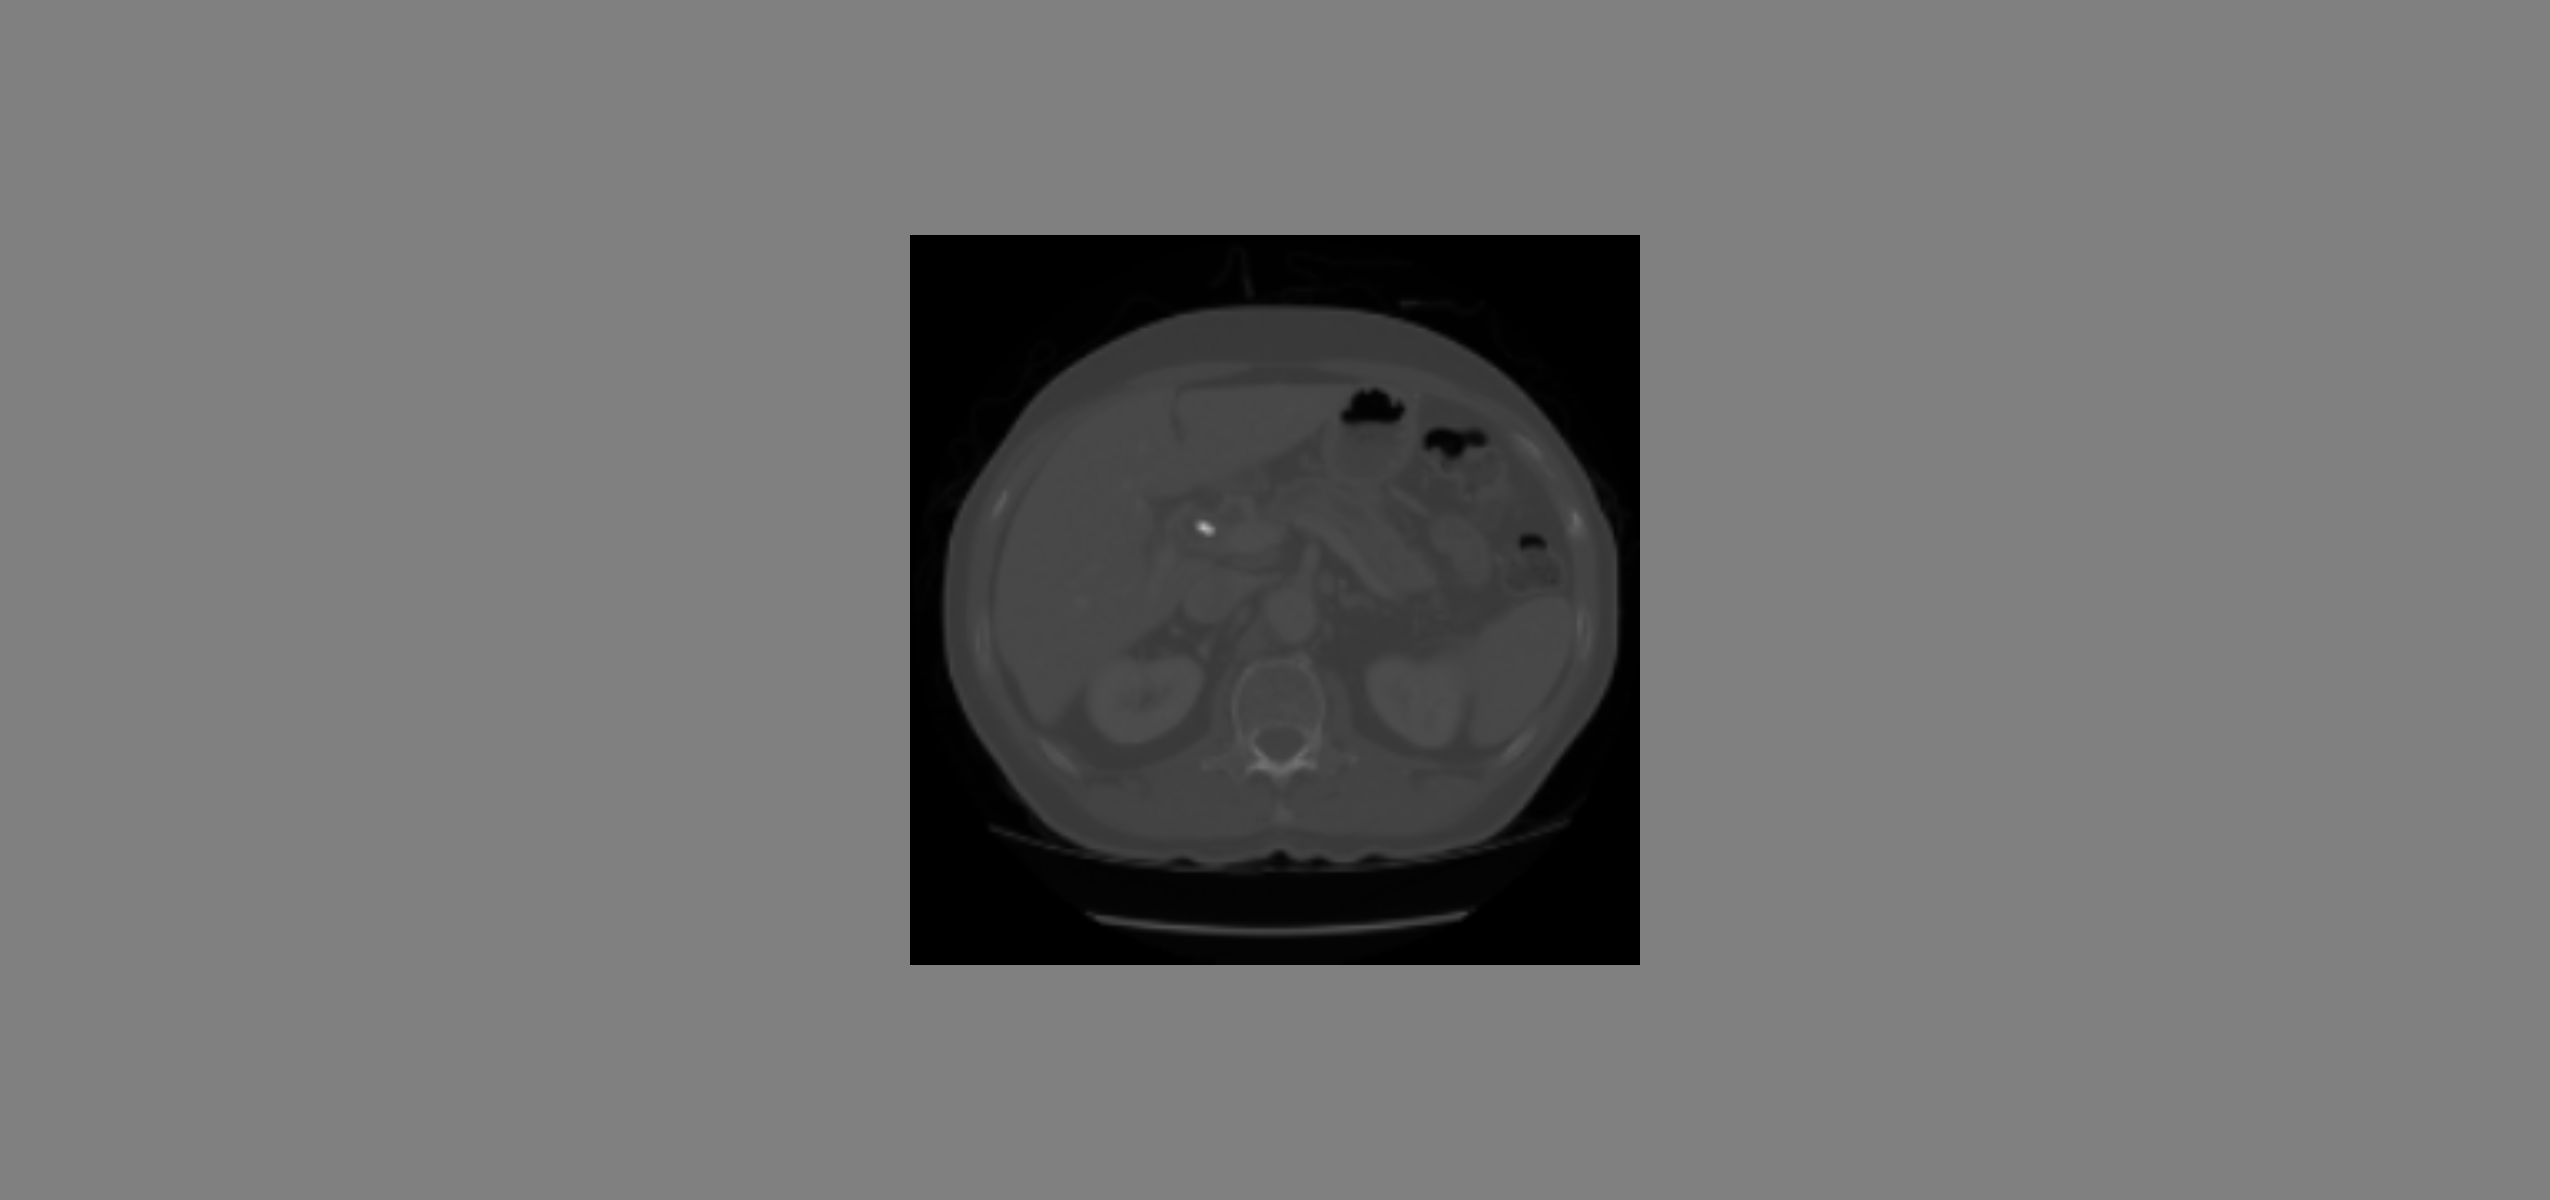
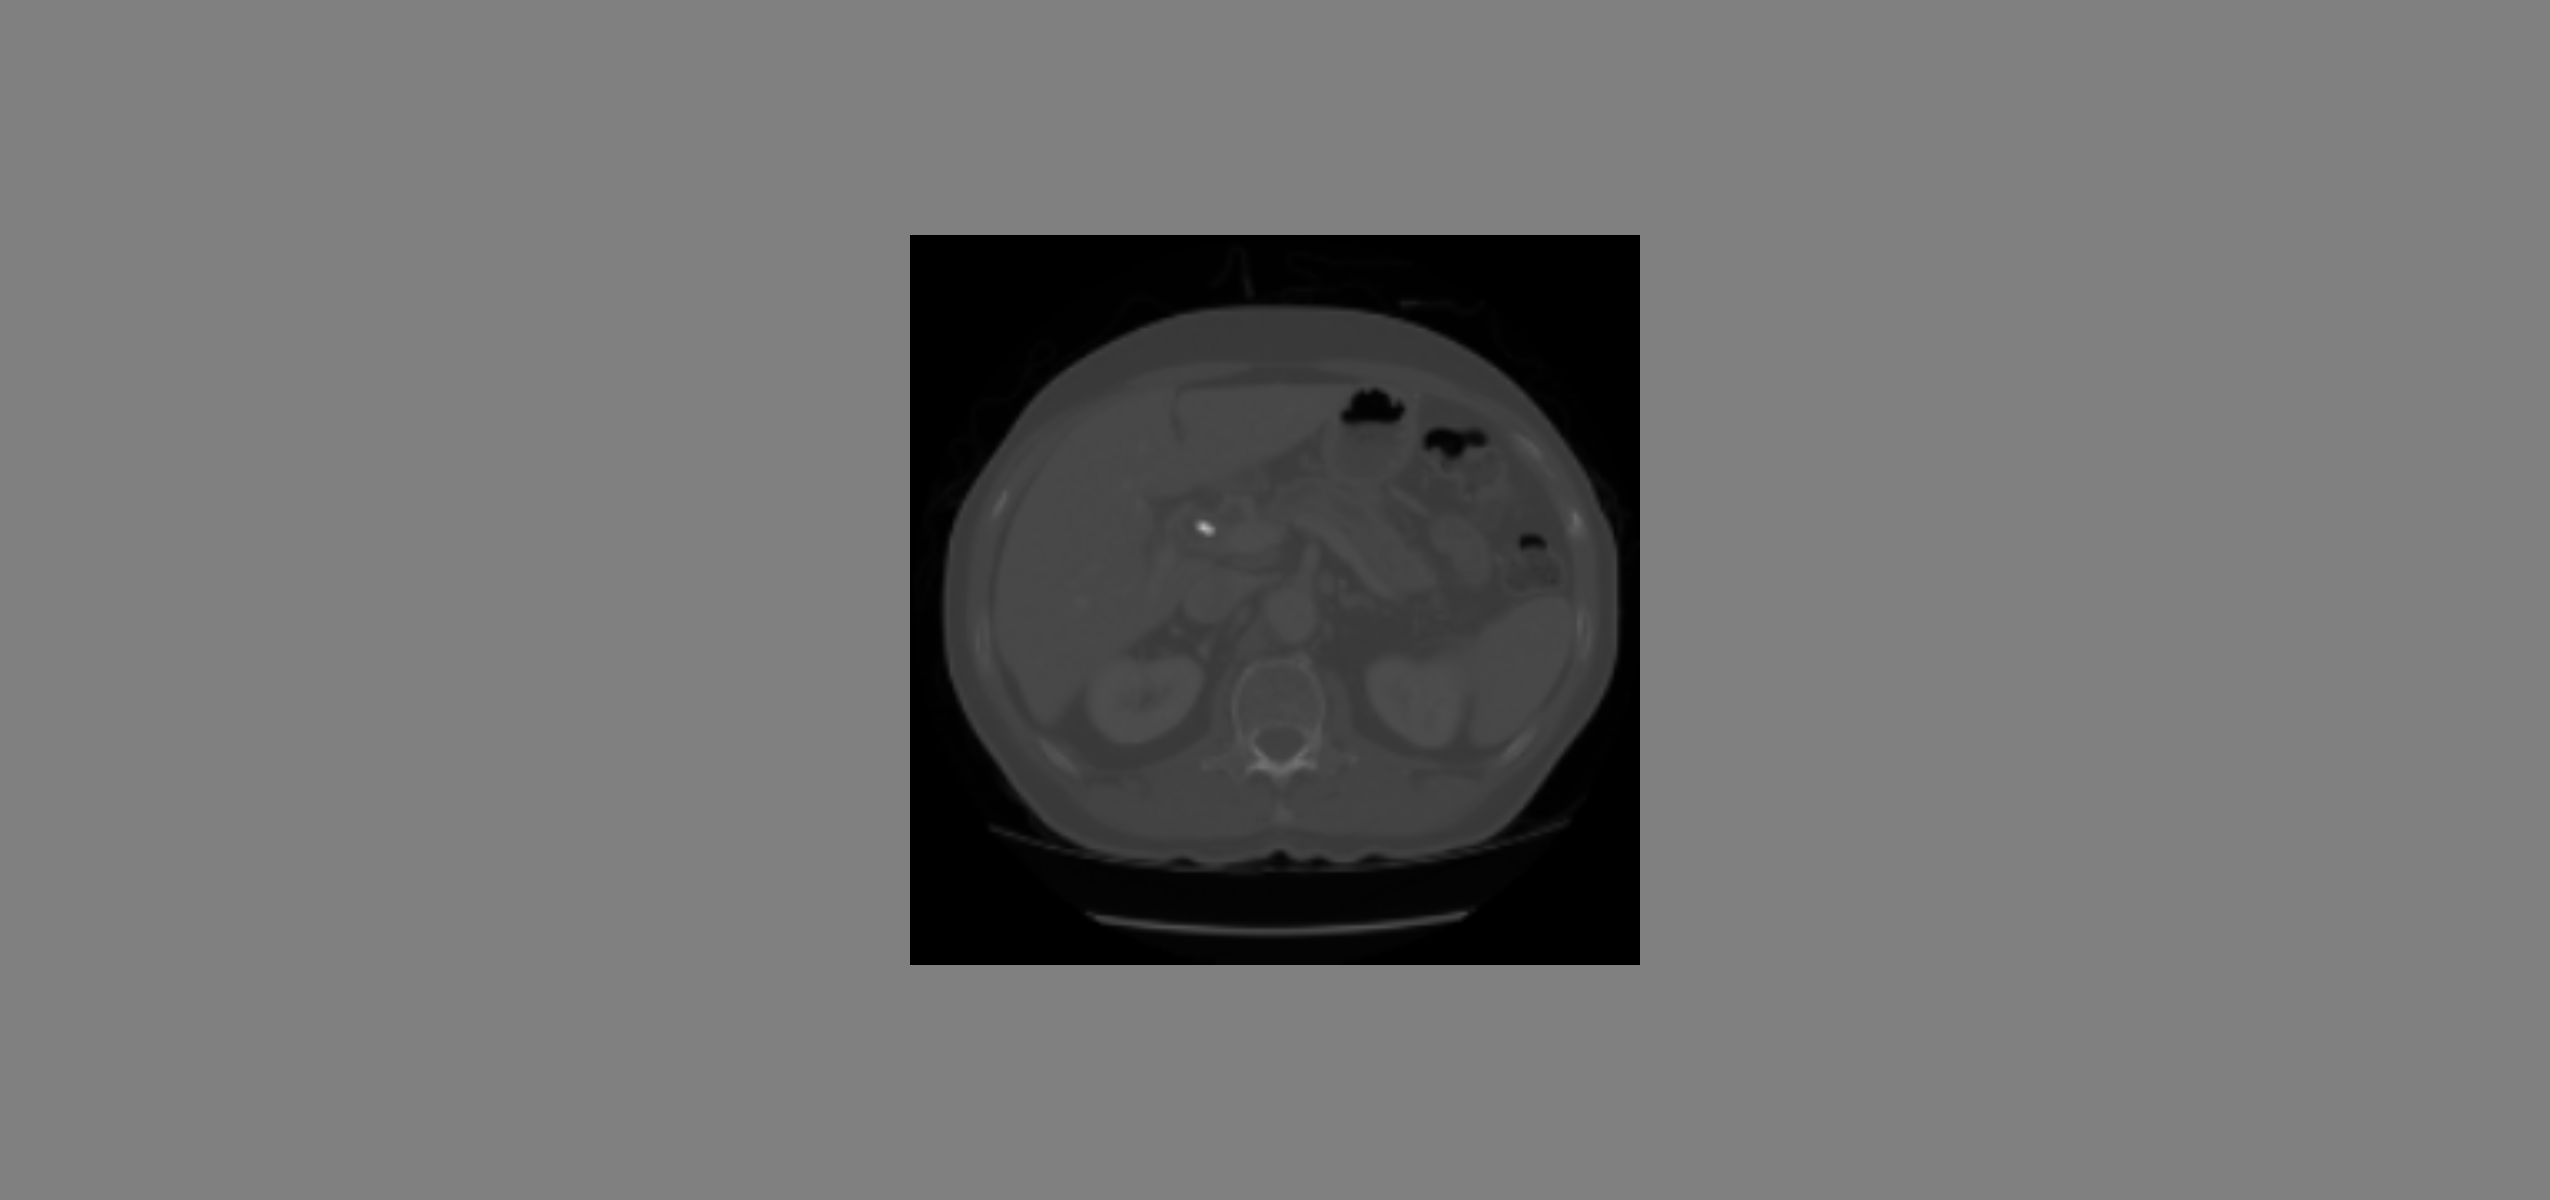

<IPython.core.display.Javascript object>

Output()

In [5]:
from ipywidgets import interact_manual, widgets, interactive_output, Button, VBox, HBox
from IPython.display import display
import numpy as np

box = VBox()
out = widgets.Output()


def clear_button_click(button):
    global viewer, mask_input
    with out:
        viewer.points.clear()
        viewer.labels.clear()
        viewer.mask_input = None
        viewer.image_patch = None
        viewer.patch_anchor = None
        viewer.mask = np.zeros(image.GetSize()[::-1])
        viewer.set_label_image(viewer.mask)
        print("Mask cleared!")

# any image should be converted into RAI orientation for visualization
# image = flip_itkimage_torai(image, interpolator="linear", pad_value=-1024)
viewer = show(image, predictor=predictor, predict_mode="full_image")
clear_button = Button(description="Clear", button_style="warning")
clear_button.on_click(clear_button_click)
box.children += (HBox([clear_button]), )
display(box, out)
